## Đồ Án Cuối Kì Nhập Môn Khoa Học Dữ Liệu

### Đề tài: Dự báo lượng mưa từ những thông số thời tiết khác như nhiệt độ, độ ẩm, áp suất không khí, ...

Thông tin nhóm
1. Nguyễn Văn Hậu - 18120359
2. Nguyễn Tấn Thìn - 18120085

## 1. Thu thập data

#### Tổng quan về Visual Crossing Timeline Weather API
- Website: `https://www.visualcrossing.com/weather-api`
- Documents: `https://www.visualcrossing.com/resources/documentation/weather-api/weather-api-documentation/#timeline`
- API cung cấp thông tin về thời tiết trong quá khứ, giữa 2 khoảng thời gian cho trước tại một địa điểm xác định và có thể có thêm thông tin dự báo thời tiết (nhưng ta sẽ không lấy thông tin này)
- Cần tạo một tài khoản để được cung cấp API key
- Mỗi API key miễn phí bị giới hạn chỉ được thu thập tối đa 1000 kết quả trả về trong một ngày

#### Cú pháp API
`https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/[location]/[date1]/[date2]?key=YOUR_API_KEY`
với:
- `location` là địa điểm cần lấy thông tin thời tiết
- `date1` là thời gian bắt đầu
- `date2` là thời gian kết thúc
- `YOUR_API_KEY` là api key cung cấp cho mỗi tài khoản đăng kí

#### Cách thu thập data
- Chúng ta tiến hành thu thập dữ liệu thời tiết trong quá khứ theo từng ngày trong thời gian từ năm 2017 đến năm 2020, cụ thể là từ **1/1/2017** đến **31/12/2020**
- Vì giới hạn mỗi API key chỉ được thu thập **tối đa 1000** kết quả một ngày nên ta sẽ dùng 2 API key, mỗi API key tương ứng thu thập dữ liệu năm 2017-2018 và năm 2019-2020

### Import

In [1]:
%matplotlib inline
import requests
import json
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

### Chuẩn bị các hàm cần thiết

Hàm thu thập data giữa 2 ngày

def collect_data(start_date, end_date, api_key):
    url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Ho%20Chi%20Minh/{start_date}/{end_date}?unitGroup=metric&key={api_key}&include=obs'
    weather_data = []
    success = False
    while success == False:
        print(f"GET: {url}")
        r = requests.get(url)
        if r.ok == True:
            # lấy kết quả json
            pydata = json.loads(r.text)
            weather_data.extend(pydata["days"])
            print("Successful! Remaining cost:", pydata['remainingCost'])
            print()

            success = True
        else:
            print("Fail! Try again. Remaining cost:", pydata['remainingCost'])
            time.sleep(5)
        
    return weather_data

Hàm thu thập toàn bộ data

def collect_all_data(start_year, end_year, api_key):
    years = list(range(start_year, end_year + 1))
    print('List years:', years)
    month_days = [
        ((1, 1), (3, 31)), 
        ((4, 1), (6, 30)),
        ((7, 1), (9, 30)),
        ((10, 1), (12, 31))
    ]
    all_weather_data = []
    
    for year in years:
        for month_day in month_days:
            start_date = f'{year}-{month_day[0][0]}-{month_day[0][1]}'
            end_date = f'{year}-{month_day[1][0]}-{month_day[1][1]}'
            print(f'({start_date} -> {end_date})', end='\n')
#             print(url)
            weather_data = collect_data(start_date, end_date, api_key)
            all_weather_data.extend(weather_data)
        print()
        
    return all_weather_data

### Tiến hành thu thập data

api_key1 = 'A29UZSNHSG8P8EPR6A4CM2UC6'
api_key2 = 'YXRHHRS6QX82D58S867TW6YBF'
all_weather_data = []

# Thu thập lần 1
start_year = 2017
end_year = 2018
weather_data = collect_all_data(start_year, end_year, api_key1)
all_weather_data.extend(weather_data)

# Thu thập lần 2
start_year = 2019
end_year = 2020
weather_data = collect_all_data(start_year, end_year, api_key2)
all_weather_data.extend(weather_data)

print('Number of data:', len(all_weather_data))

### Lưu data xuống file csv

Tạo dataframe và lưu dữ liệu xuống file `historical_weather_data.csv`

data_df = pd.DataFrame(all_weather_data)
data_df.rename(lambda name: name[0].upper() + name[1:], axis='columns', inplace=True)
data_df.to_csv('historical_weather_data.csv', index=False)
data_df.head()

## 2. Khám phá dữ liệu (để đưa ra câu hỏi)

Dữ liệu thời tiết thu thập được ở bước trước là dữ liệu tại vị trí quận 1 của Thành phố Hồ Chí Minh.  

Load dữ liệu từ file `historical_weather_data.csv`

In [2]:
data_df = pd.read_csv('historical_weather_data.csv')
data_df.head()

,Datetime,DatetimeEpoch,Tempmax,Tempmin,Temp,Feelslikemax,Feelslikemin,Feelslike,Dew,Humidity,...,Solarenergy,Sunrise,SunriseEpoch,Sunset,SunsetEpoch,Moonphase,Conditions,Icon,Stations,Source
0,2017-01-01,1483203600,34.0,23.0,27.9,35.7,23.0,29.4,22.2,74.98,...,NaN,06:11:33,1483225893,17:41:54,1483267314,0.05,"Rain, Partially cloudy",cloudy,"['48894099999', '48900099999', 'VVTS']",obs
1,2017-01-02,1483290000,33.0,23.0,28.4,36.1,23.0,30.1,21.3,67.16,...,NaN,06:11:57,1483312317,17:42:27,1483353747,0.09,Partially cloudy,partly-cloudy-day,"['48894099999', '48900099999', 'VVTS']",obs
2,2017-01-03,1483376400,33.8,24.1,28.2,35.7,24.1,29.8,21.7,69.77,...,NaN,06:12:20,1483398740,17:43:00,1483440180,0.13,Partially cloudy,partly-cloudy-day,"['48894099999', '48900099999', 'VVTS']",obs
3,2017-01-04,1483462800,32.8,24.0,27.8,35.2,24.0,29.5,21.6,70.70,...,NaN,06:12:42,1483485162,17:43:33,1483526613,0.18,Partially cloudy,partly-cloudy-day,"['48894099999', '48900099999', 'VVTS']",obs
4,2017-01-05,1483549200,32.0,25.0,28.5,34.9,25.0,30.4,22.3,71.11,...,NaN,06:13:03,1483571583,17:44:05,1483613045,0.23,Partially cloudy,partly-cloudy-day,"['48894099999', '48900099999', 'VVTS']",obs


### Số dòng và số cột của dữ liệu

In [3]:
data_df.shape

(1461, 32)

### Ý nghĩa của mỗi dòng

Mỗi dòng là thông tin thời tiết ghi nhận được của một ngày trong năm

### Ý nghĩa của mỗi cột

Dữ liệu có rất nhiều cột nhưng chúng ta chỉ quan tâm một số cột quan trọng:
- `Datetime`: ngày ghi nhận thông tin (yyyy-m-d)
- `Tempmax`: nhiệt độ cao nhất trong ngày (Celsius)
- `Tempmin`: nhiệt độ thấp nhất trong ngày (Celsius)
- `Temp`: nhiệt độ trung bình trong ngày (Celsius)
- `Dew`: điểm sương, là nhiệt độ mà tại đó hơi nước trong khối không khí ngưng đọng thành nước lỏng, độ ẩm tương đối của khối không khí đạt 100% (Celsius)
- `Humidity`: độ ẩm tương đối (%)
- `Precip`: lượng mưa (mm)
- `Precipcover`: tỉ lệ thời gian mưa trong ngày (%)
- `Windgust`: tốc độ cơn gió mạnh (tốc độ tối đa của gió thổi trong khoảng thời gian ngắn và phải trên một mức nào đó mới được ghi nhận) (kph)
- `Windspeed`: tốc độ gió trung bình (kph)
- `Winddir`: hướng gió đo so với hướng Bắc (degrees)
- `Pressure`: áp suất không khí (millibars)
- `Cloudcover`: tỉ lệ mây bao phủ bầu trời (%)
- `Visibility`: tầm nhìn xa ban ngày (km)
- `Conditions`: hiện tượng thời tiết ghi nhận được như sấm sét, mưa, ...

Chi tiết cụ thể hơn về thông tin các cột có tại `https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/`

### Kiểm tra các dòng có bị lặp không

In [4]:
data_df.index.duplicated().sum()

0

### Đặt câu hỏi

**Câu hỏi:** *Output* - độ ẩm tương đối (Humidity) được tính từ *input* - các thông số khác (nhiệt độ, điểm sương, tốc độ gió, áp suất, ...) như thế nào?  
  
**Ý nghĩa:** Khi độ ẩm tương đối quá cao (> 90%) thì con người sẽ tăng nguy cơ mắc các bệnh khớp, ho, hen suyễn hay đau đầu, ngoài ra độ ẩm tương đối quá cao cũng là điều kiện cho các loại vi khuẩn và nấm mốc phát triển. Ngược lại, khi độ ẩm tương đối quá thấp (< 30%), con người dễ bị các triệu chứng như chảy máu cam hay bị virus cảm lạnh rhinovirus xâm nhập. Do đó, dự đoán được độ ẩm tương đối sẽ hữu ích trong việc quyết định có sử dụng máy điều khiển độ ẩm để tăng giảm độ ẩm hay không. 

## 3. Tách tập, tiền xử lí và khám phá dữ liệu

### Khám phá dữ liệu cột output (để tách tập)

Kiểu dữ liệu của cột output

In [5]:
data_df['Humidity'].dtype

dtype('float64')

Kiếm tra cột output có giá trị thiếu không

In [6]:
data_df['Humidity'].isna().sum()

0

Phân bố của cột output

In [7]:
data_df['Humidity'].describe()

count    1461.000000
mean       77.909014
std         9.372152
min        50.170000
25%        71.540000
50%        78.990000
75%        85.070000
max        98.190000
Name: Humidity, dtype: float64

Nhận xét: Giá trị ở cột output dao động từ 50% đến 98%, tức là tại TP HCM trong vài năm qua không có tình trạng độ ẩm xuống quá thấp nhưng đôi lúc xảy ra tình trạng độ ẩm tăng cao (> 90%). 

In [8]:
(data_df['Humidity'] > 90).sum()

112

### Tiền xử lí (tách các tập)

Tiến hành tách tập data thu được thành 3 tập huấn luyện, validation và tập kiểm tra

In [9]:
# Tách X và y
y_sr = data_df["Humidity"]
X_df = data_df.drop("Humidity", axis = 1)

In [10]:
# Tách tập kiểm tra với tỉ lệ 30%
train_valid_X_df, test_X_df, train_valid_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size = 0.3, random_state = 0)

In [11]:
# Tách tập validation từ tập còn lại với tỉ lệ 30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(train_valid_X_df, train_valid_y_sr, test_size = 0.3, 
                                                              random_state = 0)

Tập kiểm tra

In [12]:
test_X_df.shape

(439, 31)

In [13]:
test_y_sr.shape

(439,)

Tập validation

In [14]:
val_X_df.shape

(307, 31)

In [15]:
val_y_sr.shape

(307,)

Tập huấn luyện

In [16]:
train_X_df.head().index

Int64Index([1216, 926, 609, 183, 473], dtype='int64')

### Khám phá dữ liệu (tập huấn luyện)

#### Kiểu dữ liệu hiện tại của mỗi cột

In [17]:
train_X_df.dtypes

Datetime           object
DatetimeEpoch       int64
Tempmax           float64
Tempmin           float64
Temp              float64
Feelslikemax      float64
Feelslikemin      float64
Feelslike         float64
Dew               float64
Precip            float64
Precipprob        float64
Precipcover       float64
Snow              float64
Snowdepth         float64
Windgust          float64
Windspeed         float64
Winddir           float64
Pressure          float64
Cloudcover        float64
Visibility        float64
Solarradiation    float64
Solarenergy       float64
Sunrise            object
SunriseEpoch        int64
Sunset             object
SunsetEpoch         int64
Moonphase         float64
Conditions         object
Icon               object
Stations           object
Source             object
dtype: object

Nhận xét: Phần lớn cột trong dữ liệu input là ở dạng số

#### Phân bố của các cột dữ liệu dạng số

In [18]:
num_cols = list(train_X_df.dtypes[train_X_df.dtypes == float].index)
num_cols

['Tempmax',
 'Tempmin',
 'Temp',
 'Feelslikemax',
 'Feelslikemin',
 'Feelslike',
 'Dew',
 'Precip',
 'Precipprob',
 'Precipcover',
 'Snow',
 'Snowdepth',
 'Windgust',
 'Windspeed',
 'Winddir',
 'Pressure',
 'Cloudcover',
 'Visibility',
 'Solarradiation',
 'Solarenergy',
 'Moonphase']

In [19]:
df = train_X_df[num_cols]

def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)

df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Tempmax,Tempmin,Temp,Feelslikemax,Feelslikemin,Feelslike,Dew,Precip,Precipprob,Precipcover,...,Snowdepth,Windgust,Windspeed,Winddir,Pressure,Cloudcover,Visibility,Solarradiation,Solarenergy,Moonphase
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,100.0,0.00,...,100.0,83.6,0.0,0.0,1.0,0.0,0.0,100.0,100.0,0.0
min,24.6,20.0,22.8,0.0,0.0,22.8,15.2,0.0,NaN,0.00,...,NaN,25.9,8.1,54.8,1004.4,22.5,6.2,NaN,NaN,0.0
lower_quartile,32.0,24.0,27.4,36.2,24.0,29.5,22.5,0.0,NaN,0.00,...,NaN,33.5,15.2,143.2,1008.5,44.4,9.0,NaN,NaN,0.2
median,33.0,25.0,28.3,38.6,25.0,31.2,24.4,0.0,NaN,0.00,...,NaN,40.7,18.4,182.1,1009.8,52.6,9.6,NaN,NaN,0.5
upper_quartile,34.0,26.0,29.0,40.6,26.0,33.0,25.2,1.0,NaN,4.20,...,NaN,48.2,21.3,236.8,1011.3,60.0,10.1,NaN,NaN,0.8
max,37.0,29.0,32.1,48.5,35.6,39.3,26.9,88.5,NaN,16.67,...,NaN,74.2,40.7,316.2,1015.7,99.6,10.7,NaN,NaN,1.0


#### Phân bố của các cột dữ liệu không phải dạng số

In [20]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = ['Datetime', 'Sunrise', 'Sunset', 'Conditions', 'Icon']
cat_multi_cols = ['Conditions']
df = train_X_df[cat_cols]

def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    if c.name in cat_multi_cols:
        s = c.str.split(', ').explode().value_counts(normalize=True)
        return dict((s * 100).round(1))
    else:
        return dict((c.value_counts(normalize=True) * 100).round(1))
    
df.agg([missing_ratio, num_values, value_ratios])

,Datetime,Sunrise,Sunset,Conditions,Icon
missing_ratio,0,0,0,0,0
num_values,715,579,589,5,5
value_ratios,"{'2017-09-01': 0.1, '2020-06-06': 0.1, '2020-06-21': 0.1, '2018-04-03': 0.1, '2020-01-19': 0.1, '2018-10-08': 0.1, '2019-06-04': 0.1, '2017-10-22': 0.1, '2020-01-07': 0.1, '2018-08-12': 0.1, '2018...","{'05:41:51': 1.1, '05:41:50': 1.0, '05:43:32': 1.0, '05:43:21': 0.7, '05:43:33': 0.6, '05:43:24': 0.6, '06:16:54': 0.6, '05:43:26': 0.6, '05:43:34': 0.6, '05:43:14': 0.4, '05:41:59': 0.4, '05:43:0...","{'18:04:04': 3.6, '18:04:03': 1.5, '18:04:05': 1.3, '17:26:37': 0.7, '18:20:02': 0.7, '18:03:59': 0.6, '18:20:00': 0.6, '18:20:04': 0.6, '17:26:38': 0.6, '17:26:48': 0.4, '18:04:24': 0.4, '17:26:4...","{'Partially cloudy': 68.0, 'Rain': 27.3, 'Overcast': 4.1, 'Clear': 0.6}","{'partly-cloudy-day': 59.9, 'rain': 26.2, 'cloudy': 11.5, 'wind': 1.7, 'clear-day': 0.8}"


In [21]:
data_df['Conditions'].str.split(', ').explode().value_counts(normalize=True)

Partially cloudy    0.666337
Rain                0.276733
Overcast            0.047030
Clear               0.009901
Name: Conditions, dtype: float64

## 4. Tiền xử lí và mô hình hóa dữ liệu

Dữ liệu của ta có khá nhiều cột nhưng nhận thấy chỉ một số cột (có thể) ảnh hưởng đến kết quả độ ẩm tương đối. Đó là các cột:
- Nhiệt độ (Temp)
- Nhiệt độ cao nhất (Tempmax)
- Nhiệt độ thấp nhất (Tempmin)
- Độ sương (Dew)
- Tốc độ gió (Windspeed)
- Hướng gió (Winddir)
- Áp suất (Pressure)
- Độ bao phủ của mây (Cloudcover)
- Tầm nhìn (Visibility)
- Icon

### Tiền xử lí tập huấn luyện

Đầu tiên, ta xử lí thêm bớt một số cột như sau:
- Tạo thêm 2 cột là Day và Month lấy thông tin ngày, tháng từ cột Datetime. Sau đó bỏ cột Datetime.
- Bỏ các cột DatetimeEpoch, Feelslikemax, Feelslikemin, Feelslike, Precip, Precipprob, Precipcover, Sunrise, SunriseEpoch, Sunset, SunsetEpoch, Moonphase, Stations, Source vì các cột này không mang lại nhiều thông tin hữu ích.
- Bỏ các cột Snow, Snowdepth, Windgust, Solarradiation, Solarenergy vì chứa nhiều giá trị trống (NaN).
- Bỏ cột Conditions vì nhìn qua thì cột Conditions và cột Icon khá tương quan với nhau nên ta chỉ lấy cột Icon.

Với các cột dữ liệu dạng số ta sẽ điền giá trị thiếu bằng mean của cột bằng cách sử dụng `SimpleImputer`

In [22]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y = None):
        return self
    def transform(self, X_df, y = None):
        # YOUR CODE HERE
        df = X_df.copy()
        month_sr = df['Datetime'].str.split('-').apply(lambda x: x[1])
        day_sr = df['Datetime'].str.split('-').apply(lambda x: x[2])
        df.insert(0, 'Day', day_sr)
        df.insert(0, 'Month', month_sr)
        df.drop(['Datetime', 'DatetimeEpoch', 'Feelslikemax', 'Feelslikemin', 'Feelslike', 'Precip', 'Precipprob',
                 'Precipcover', 'Sunrise', 'SunriseEpoch', 'Sunset', 'SunsetEpoch', 'Moonphase', 'Stations', 'Source', 'Snow',
                 'Snowdepth', 'Windgust', 'Solarradiation', 'Solarenergy', 'Conditions'], axis = 1, inplace = True)
        return df

In [23]:
# TEST TRANSFORM METHOD
col_adderdropper = ColAdderDropper()
fewer_cols_train_X_df = col_adderdropper.transform(train_X_df)
fewer_cols_train_X_df.head()

,Month,Day,Tempmax,Tempmin,Temp,Dew,Windspeed,Winddir,Pressure,Cloudcover,Visibility,Icon
1216,05,01,36.2,27.0,30.8,21.9,22.3,132.5,1009.2,34.5,10.4,partly-cloudy-day
926,07,16,33.1,24.0,28.1,25.3,23.8,252.4,1006.3,61.7,9.0,rain
609,09,02,34.0,25.4,29.4,25.5,20.5,266.7,1007.9,64.5,9.4,cloudy
183,07,03,33.0,25.0,28.6,24.5,18.4,233.0,1008.6,53.2,10.2,partly-cloudy-day
473,04,19,34.0,27.0,29.9,23.4,18.0,140.4,1009.8,51.8,10.3,partly-cloudy-day


Đến đây, các cột dạng số (numerical) gồm: "Month", "Day", "Tempmax", "Tempmin", "Temp", "Dew", "Windspeed", "Winddir", "Pressure", "Cloudcover", "Visibility"; cột duy nhất không phải dạng số (categorical) và không có thứ tự là cột "Icon"; không có cột không phải dạng số và có thứ tự. Các bước tiền xử lý tiếp theo như sau:
- Với các cột dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean của cột. Với *tất cả* các cột dạng số trong tập huấn luyện, ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới. 
- Với các cột không phải dạng số và không có thứ tự:
    - Ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột. Với *tất cả* các cột không có dạng số và không có thứ tự, ta đều cần tính mode, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới.
    - Sau đó, ta sẽ chuyển sang dạng số bằng phương pháp mã hóa one-hot.
- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn.

In [24]:
nume_cols = ['Month', 'Day', 'Tempmax', 'Tempmin', 'Temp', 'Dew', 'Windspeed', 'Winddir', 'Pressure', 'Cloudcover',
             'Visibility']
unorder_cate_cols = ['Icon']

nume_imputer = [('imputer', SimpleImputer(missing_values = np.nan, strategy = 'mean'))]
unorder_cate_imputer = [('imputer', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')), 
                        ('encoder', OneHotEncoder(handle_unknown = "ignore"))]

nume_transform = Pipeline(nume_imputer)
unorder_cate_transform = Pipeline(unorder_cate_imputer)

col_transform = [('nume', nume_transform, nume_cols), ('unorder_cate', unorder_cate_transform, unorder_cate_cols)]
transformer = ColumnTransformer(col_transform)

preprocess_pipeline = Pipeline(steps = [('col_adderdropper', ColAdderDropper()), ('transformer', transformer),
                                        ('scaler', StandardScaler())])
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)
# TEST
preprocess_pipeline

Pipeline(steps=[('col_adderdropper', ColAdderDropper()),
                ('transformer',
                 ColumnTransformer(transformers=[('nume',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Month', 'Day', 'Tempmax',
                                                   'Tempmin', 'Temp', 'Dew',
                                                   'Windspeed', 'Winddir',
                                                   'Pressure', 'Cloudcover',
                                                   'Visibility']),
                                                 ('unorder_cate',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Icon'])])),
                ('scaler', StandardScaler())])

### Tiền xử lí tập validation

In [25]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)

### Kết hợp tiền xử lí và mô hình hóa

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số `hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500`) và đặt tên cho pipeline này là full_pipeline. 
Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `alpha` (mức độ L2 regularization hay weight decay) của `MLPRegressor` với 10 giá trị khác nhau: 0.0001, 0.001, 0.01 0.1, 1, 10, 100, 1000, 10000, 100000.
Để gán lại giá trị `alpha` cho `full_pipeline`, ta sẽ dùng phương thức `set_params`: 
`full_pipeline.set_params(mlpregressor__alpha=...)`
Như vậy, tổng cộng ta sẽ thử nghiệm 10 mô hình khác nhau, với mỗi mô hình ta sẽ: huấn luyện trên tập huấn luyện, tính độ lỗi trên tập huấn luyện và tập validation rồi `append` độ lỗi vào 2 list tương ứng là `train_errs` và `var_errs` (để dễ nhìn, ta tính độ lỗi theo đơn vị %, nghĩa là có giá trị từ 0-100). Sau đó lưu lại độ lỗi nhỏ nhất trên tập validation và giá trị `alpha` tương ứng lần lượt vào biến `best_val_err` và `best_alpha`.

In [26]:
# Tạo full_pipeline
nume_cols = ['Month', 'Day', 'Tempmax', 'Tempmin', 'Temp', 'Dew', 'Windspeed', 'Winddir', 'Pressure', 'Cloudcover',
             'Visibility']
unorder_cate_cols = ['Icon']
full_pipeline = Pipeline(steps = [('col_adderdropper', ColAdderDropper()), ('transformer', transformer),
                                  ('scaler', StandardScaler()), ('mlpregressor', MLPRegressor(hidden_layer_sizes = (20), 
                                                                                              activation = 'tanh', 
                                                                                              solver = 'lbfgs', 
                                                                                              random_state = 0, 
                                                                                              max_iter = 2500))])

# Thử nghiệm với nhiều giá trị khác nhau của siêu tham số
#mlpregressor__alpha, mlpregressor__max_iter, mlpregressor__hidden_layer_sizes
train_errs = []
val_errs = []
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000, 100000]
best_val_err = float('inf'); best_alpha = None;

for alpha in alphas:
    full_pipeline.set_params(mlpregressor__alpha = alpha)
    full_pipeline.fit(train_X_df, train_y_sr)
    train_err = (1 - full_pipeline.score(train_X_df, train_y_sr)) * 100
    train_errs.append(train_err)
    val_err = (1 - full_pipeline.score(val_X_df, val_y_sr)) * 100
    val_errs.append(val_err)
        
    # Lưu thông tin mô hình tốt nhất
    if val_err < best_val_err:
        best_val_err = val_err
        best_alpha = alpha
'Finish!'

c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: C

'Finish!'

In [27]:
# Test
full_pipeline

Pipeline(steps=[('col_adderdropper', ColAdderDropper()),
                ('transformer',
                 ColumnTransformer(transformers=[('nume',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Month', 'Day', 'Tempmax',
                                                   'Tempmin', 'Temp', 'Dew',
                                                   'Windspeed', 'Winddir',
                                                   'Pressure', 'Cloudcover',
                                                   'Visibility']),
                                                 ('unorder_cate',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Icon'])])),
                ('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=100000,
                              hidden_layer_sizes=20, max_iter=2500,
                              random_state=0, solver='lbfgs'))])

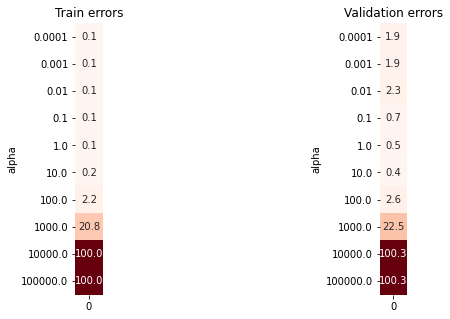

In [28]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data = np.array(train_errs).reshape(len(alphas), -1), index = alphas)
val_errs_df = pd.DataFrame(data = np.array(val_errs).reshape(len(alphas), -1), index = alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin = min_err, vmax = max_err, square = True, annot = True, cbar = False, fmt = '.1f',
            cmap = 'Reds')
plt.title('Train errors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin = min_err, vmax = max_err, square = True, annot = True, cbar = False, fmt = '.1f', cmap = 'Reds')
plt.title('Validation errors'); plt.ylabel('alpha');

#### Huấn luyện lại mô hình với kết quả siêu tham số tốt nhất

In [29]:
full_pipeline.set_params(mlpregressor__alpha = best_alpha)
full_pipeline.fit(train_X_df, train_y_sr)

Pipeline(steps=[('col_adderdropper', ColAdderDropper()),
                ('transformer',
                 ColumnTransformer(transformers=[('nume',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Month', 'Day', 'Tempmax',
                                                   'Tempmin', 'Temp', 'Dew',
                                                   'Windspeed', 'Winddir',
                                                   'Pressure', 'Cloudcover',
                                                   'Visibility']),
                                                 ('unorder_cate',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Icon'])])),
                ('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=10,
                              hidden_layer_sizes=20, max_iter=2500,
                              random_state=0, solver='lbfgs'))])

### Đánh giá mô hình tìm được

**Độ chính xác trên tập huấn luyện**

In [30]:
full_pipeline.score(train_X_df, train_y_sr)

0.9979036360900754

**Độ chính xác trên tập validation**

In [31]:
full_pipeline.score(val_X_df, val_y_sr)

0.9960978904467569